<a href="https://colab.research.google.com/github/ehtisham-Fazal/ACP_SRC/blob/main/new_results_ACP_SRC_740_Python_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, os, re, gc
import numpy as np
import pandas as pd
from random import sample

## Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras import metrics
from keras import optimizers
from keras.utils.np_utils import to_categorical

import numpy.linalg as LA
from sklearn.model_selection import train_test_split

## Perfmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_curve,roc_auc_score


## utilities
from matplotlib import pyplot as plt
!pip install wget
import wget


## pre-processing
from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import KernelPCA
from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE, KMeansSMOTE, BorderlineSMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=1939eaf57f21806e52d6529304a896f8ab59d68c9b1d597f2a40efea7dd7b7c2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
file1_path = 'https://raw.githubusercontent.com/NLPrinceton/sparse_recovery/master/solvers.py'
wget.download(file1_path, 'solvers.py')
from solvers import *

dataset_path='http://www.cczubio.top/static/ACP-check/datasets/ACP-DL/acp740.txt'
wget.download(dataset_path, 'acp740.txt')

'acp740.txt'

In [3]:
def prepare_feature_acp740():
    path = r"acp740.txt"
    new_list=[]
    seq_list=[]
    label = []
    lis = []
    lx=[]
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 0
    with open(path, 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]            
                proteinName = values[0]
                proteinName_1=proteinName.split("_")
                new_list.append(proteinName_1[0])   

                if label_temp == '1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                seq_list.append(seq)
        for i, item in enumerate(new_list):
            lis.append([item, seq_list[i]])
        for i in lis:
            if len(i[1])>60:
                x=([i[0],i[1][0:60]])
                lx.append(x)
            else:
                lx.append(i)        
    return lx 
 



In [4]:
def yoden_index(y, y_pred):
  epsilon = 1e-30
  tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
  j = (tp/(tp + fn + epsilon)) + (tn/(tn+fp + epsilon)) - 1
  return j

def pmeasure(y, y_pred):
    epsilon = 1e-30
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
    sensitivity = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    f1score = (2 * tp) / (2 * tp + fp + fn + epsilon)
    return ({'Sensitivity': sensitivity, 'Specificity': specificity, 'F1-Score': f1score})
    
def Calculate_Stats(y_actual,y_pred):
  acc = accuracy_score(y_actual, y_pred)
  sen = pmeasure(y_actual, y_pred)['Sensitivity']
  spe = pmeasure(y_actual, y_pred)['Specificity']
  f1 = pmeasure(y_actual, y_pred)['F1-Score']
  mcc = matthews_corrcoef(y_actual, y_pred)
  bacc = balanced_accuracy_score(y_actual, y_pred)
  yi = yoden_index(y_actual, y_pred)
  return acc, sen, spe, f1, mcc, bacc, yi

In [5]:
def Test_SRC(A,delta_y,DATA,LABEL,solver='BP',verbose=0, x0=None, ATinvAAT=None, nnz=None, positive=False, tol=1E-4, niter=100, biter=32):
  LABEL_PRED = []
  SCORE_PRED=[]
  count = 0
  for ind in range(0,DATA.shape[1]):
    b = DATA[:,ind]
    if(solver=='BP'):     
      x = BasisPursuit(A, b, x0=x0, ATinvAAT=ATinvAAT, positive=positive, tol=tol, niter=niter, biter=biter)
    elif(solver=='MP'):      
      x = MatchingPursuit(A, b, tol=tol, nnz=nnz, positive=positive)
 
    label_out, score_out = delta_rule(A,delta_y,x,b)
    if (verbose):
      check = label_out==LABEL[ind]
      if (check):
        count = count + 1
      accuracy = 100*count/(ind+1)
      print(ind+1, count, accuracy, LABEL[ind], label_out, check)
    LABEL_PRED.append(label_out)
    SCORE_PRED.append(score_out)

  return np.array(LABEL_PRED), np.array(SCORE_PRED)

In [6]:
def delta_rule(A,delta_y,x,b):
  delta1 = 0*x
  delta2 = 0*x
  delta1[delta_y==1]=x[delta_y==1]
  delta2[delta_y==0]=x[delta_y==0]
  y1 = np.matmul(A,delta1)
  y2 = np.matmul(A,delta2)
  r1 = np.linalg.norm(y1-b)
  r2 = np.linalg.norm(y2-b)

  if(r1<r2):
    label = 1
  else:
    label = 0
  score=(r2)/(r1+r2)

  return label, score


In [7]:
def Convert_Seq2CKSAAP(train_seq, gap=8):
  cksaapfea = []
  seq_label = []
  for sseq in train_seq:
    temp= CKSAAP([sseq], gap=8)
    cksaapfea.append(temp[1][1:])
    seq_label.append(sseq[0])

  x = np.array(cksaapfea)
  y = np.array(seq_label)
  y[y=='ACP']=1
  y[y=='non-ACP']=0
  y = to_categorical(y)
  print('num pos:', sum(y[:,0]==1), 'num neg:', sum(y[:,0]==0))
  return x,y

def minSequenceLength(fastas):
    minLen = 10000
    for i in fastas:
        if minLen > len(i[1]):
            minLen = len(i[1])
    return minLen

def CKSAAP(fastas, gap=5, **kw):
    if gap < 0:
        print('Error: the gap should be equal or greater than zero' + '\n\n')
        return 0

    if minSequenceLength(fastas) < gap+2:
        print('Error: all the sequence length should be larger than the (gap value) + 2 = ' + str(gap+2) + '\n' + 'Current sequence length ='  + str(minSequenceLength(fastas)) + '\n\n')
        return 0

    AA = 'ACDEFGHIKLMNPQRSTVWY'
    encodings = []
    aaPairs = []
    for aa1 in AA:
        for aa2 in AA:
            aaPairs.append(aa1 + aa2)
    header = ['#']
    for g in range(gap+1):
        for aa in aaPairs:
            header.append(aa + '.gap' + str(g))
    encodings.append(header)
    for i in fastas:
        name, sequence = i[0], i[1]
        code = [name]
        for g in range(gap+1):
            myDict = {}
            for pair in aaPairs:
                myDict[pair] = 0
            sum = 0
            for index1 in range(len(sequence)):
                index2 = index1 + g + 1
                if index1 < len(sequence) and index2 < len(sequence) and sequence[index1] in AA and sequence[index2] in AA:
                    myDict[sequence[index1] + sequence[index2]] = myDict[sequence[index1] + sequence[index2]] + 1
                    sum = sum + 1
            for pair in aaPairs:
                code.append(myDict[pair] / sum)
        encodings.append(code)
    return encodings

In [10]:
from sklearn.model_selection import KFold, StratifiedKFold
gaps = 8
loop_ind = 0
stats = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
[DataX, LabelY] = Convert_Seq2CKSAAP(prepare_feature_acp740(), gap=8)     
for train_index, test_index in kf.split(DataX,np.argmax(LabelY,axis=1)):
    loop_ind = loop_ind + 1
    X_train_1, X_test = DataX[train_index], DataX[test_index]
    y_train, y_test = LabelY[train_index], LabelY[test_index]
    print('num pos train:', sum(y_train[:,0]==1), 'num neg train:', sum(y_train[:,0]==0))
    y_train = y_train[:,0]
    y_test=y_test[:,0]  

    print('Fold # ', loop_ind)
    ## pre-processing PCA
    normalizer = Normalizer().fit(X_train_1)  
    X_train = normalizer.transform(X_train_1)
    X_test = normalizer.transform(X_test)
    oversampler = KMeansSMOTE(random_state=42)    
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    print('After Resampling \n','num pos train:', sum(y_train==1), 'num neg train:', sum(y_train==0))
    transformer = KernelPCA(n_components=70, kernel='poly') # 'linear', 'poly', 'rbf', ‘sigmoid’, ‘cosine’
    transformer.fit_transform(X_train)
    X_train = transformer.transform(X_train)
    X_test = transformer.transform(X_test)  
    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)
    # y_train_pred = Test_SRC(X_train,y_train,X_train,y_train,1)
    # tr_acc, tr_sen, tr_spe, tr_f1, tr_mcc, tr_bacc, tr_yi = Calculate_Stats(y_train, y_train_pred)
    y_test_pred,y_test_score= Test_SRC(X_train,y_train,X_train,y_train,solver='BP',verbose=0, x0=None, ATinvAAT=None, nnz=None, positive=True, tol=1E-4, niter=100, biter=32)

    # tr_acc, tr_sen, tr_spe, tr_f1, tr_mcc, tr_bacc, tr_yi = Calculate_Stats(y_train, y_train_pred)
    t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi = Calculate_Stats(y_test,y_test_pred)
    
    print(t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi)

    stats.append([t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi])



print('Mean stats:', np.mean(stats,axis=0))
print('Std stats:', np.std(stats,axis=0))
x=np.mean(stats,axis=0)
print("B_ACC={}, MCC={}, Youden's_index={}".format(x[5],x[4],x[6]))
###AUC ROC CURVE
r_auc = roc_auc_score(y_test,y_test_score)
r_fpr, r_tpr, _ = roc_curve(y_test,y_test_score)
plt.plot(r_fpr, r_tpr, linestyle='--', label='ACP_SRC (AUROC = %0.3f)' % r_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

num pos: 364 num neg: 376
num pos train: 292 num neg train: 300
Fold #  1
After Resampling 
 num pos train: 302 num neg train: 300


ValueError: ignored

In [12]:
df=pd.DataFrame(X_train_1)

In [31]:
df.columns.shape

(3600,)

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
x_scaled = StandardScaler().fit_transform(df)

In [58]:
import matplotlib.pyplot as plt 
import seaborn as sns
 
from sklearn.decomposition import PCA
sns.set()
 
# Reduce from 4 to 3 features with PCA
pca = PCA(n_components=500)
 
# Fit and transform data
pca.fit_transform(x_scaled)
 
# # Bar plot of explained_variance
# plt.bar(
#     range(1,len(pca.explained_variance_)+1),
#     pca.explained_variance_,width=0.8
#     )
 
 
# plt.xlabel('PCA Feature')
# plt.ylabel('Explained variance')
# plt.title('Feature Explained Variance')
# plt.show()

array([[-6.53930833,  0.84434097, -0.95874678, ...,  0.85992748,
        -0.85589323, -0.67025524],
       [-7.75325068, -4.50595527, -7.82379705, ...,  0.89430894,
        -0.46604137, -0.68282642],
       [-8.04241238, -4.80451984, -8.04282604, ...,  0.7871746 ,
        -0.23846612,  0.68633704],
       ...,
       [ 9.73554278,  0.38008032, -0.49961246, ...,  0.17892199,
         0.41323198,  0.39560305],
       [ 9.08130424, -0.8207202 , -0.07301976, ..., -0.15770761,
        -0.32095404,  0.516865  ],
       [ 4.13717349,  1.51826267, -1.58062966, ...,  0.15919246,
        -0.17148263,  0.04892675]])

In [59]:
covar_matrix=pca

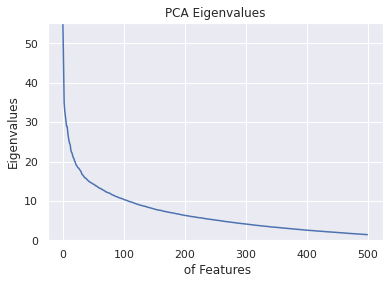

In [64]:
plt.ylabel('Eigenvalues') 
plt.xlabel(' of Features') 
plt.title('PCA Eigenvalues') 
plt.ylim(0, max(pca.explained_variance_)) 
plt.style.context('seaborn-whitegrid') 
plt.axhline (500, color='r', linestyle='-.') 
plt.plot(covar_matrix.explained_variance_) 
plt.show()

In [62]:
transformer = KernelPCA(n_components=70, kernel='poly') # 'linear', 'poly', 'rbf', ‘sigmoid’, ‘cosine’
transformer.fit_transform(X_train)
X_train = transformer.transform(X_train)


In [63]:
X_train.shape

(70, 70)

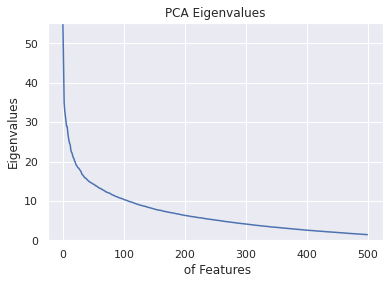

In [65]:
plt.ylabel('Eigenvalues') 
plt.xlabel(' of Features') 
plt.title('PCA Eigenvalues') 
plt.ylim(0, max(pca.explained_variance_)) 
plt.style.context('seaborn-whitegrid') 
plt.axhline (500, color='r', linestyle='-.') 
plt.plot(covar_matrix.explained_variance_) 
plt.show()

In [16]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components=500)
 
pca_features = pca.fit_transform(x_scaled)
 
print('Shape before PCA: ', x_scaled.shape)
print('Shape after PCA: ', pca_features.shape)
 
pca_df = pd.DataFrame(
    data=pca_features)
    # columns=['PC1', 'PC2', 'PC3']

Shape before PCA:  (592, 3600)
Shape after PCA:  (592, 500)


PCA(n_components=3600)